In [6]:
# install tensorflow 2.0 hub in the current Jupyter cell
import sys
!{sys.executable} -m pip install tensorflow_hub


### Import Libraries

In [7]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

### Load Data and Plot Samples

In [21]:
TRAIN_DIR = ('/Users/michaeldionne/Documents/GitHub/Group Projects/Project-2-Emotional-recognition/Resources/Kaggle_emotional dataset/Training/Training/')
TEST_DIR = ('/Users/michaeldionne/Documents/GitHub/Group Projects/Project-2-Emotional-recognition/Resources/Kaggle_emotional dataset/Testing/Testing/')

In [23]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels
    

In [24]:
IMG_SIZE= (48, 48)

In [25]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


28273 images loaded from /Users/michaeldionne/Documents/GitHub/Group Projects/Project-2-Emotional-recognition/Resources/Kaggle_emotional dataset/Training/Training/ directory.


In [26]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [27]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)


100%|██████████| 6/6 [00:00<00:00, 15.52it/s]

7067 images loaded from /Users/michaeldionne/Documents/GitHub/Group Projects/Project-2-Emotional-recognition/Resources/Kaggle_emotional dataset/Testing/Testing/ directory.


In [28]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

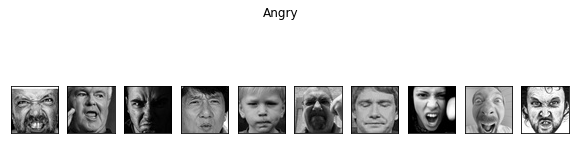

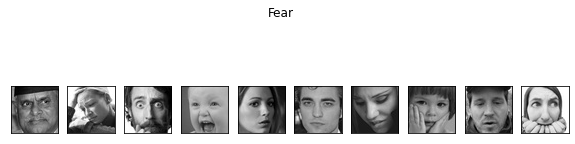

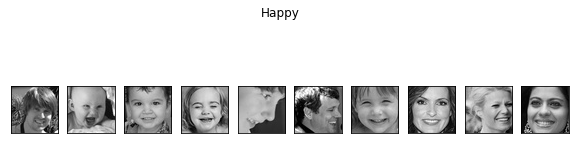

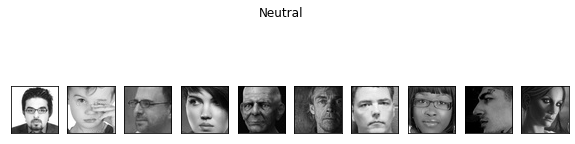

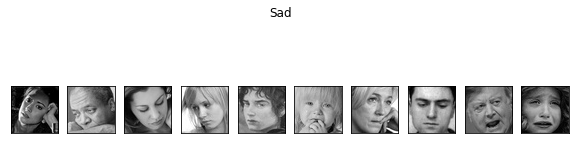

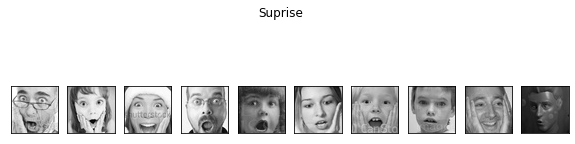

In [29]:
plot_samples(X_train, y_train, train_labels, 10)

In [30]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(28273, 6)

In [31]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape


(7067, 6)

In [32]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False, 
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-09-26 23:26:09.550757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-26 23:26:09.551285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [33]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [34]:
def deep_model(model, X_train, Y_train, epochs, batch_size):
   
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1)
    return history

In [35]:
epochs = 40
batch_size = 64

history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/40


2022-09-26 23:27:02.085818: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-26 23:27:02.864561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


442/442 [==============================] - 40s 78ms/step - loss: 0.4600 - accuracy: 0.2471
Epoch 2/40
442/442 [==============================] - 36s 81ms/step - loss: 0.4461 - accuracy: 0.2533
Epoch 3/40
442/442 [==============================] - 36s 82ms/step - loss: 0.4047 - accuracy: 0.3433
Epoch 4/40
442/442 [==============================] - 36s 82ms/step - loss: 0.3681 - accuracy: 0.4242
Epoch 5/40
442/442 [==============================] - 36s 81ms/step - loss: 0.3431 - accuracy: 0.4777
Epoch 6/40
442/442 [==============================] - 36s 82ms/step - loss: 0.3223 - accuracy: 0.5160
Epoch 7/40
442/442 [==============================] - 35s 80ms/step - loss: 0.3049 - accuracy: 0.5470
Epoch 8/40
442/442 [==============================] - 36s 80ms/step - loss: 0.2885 - accuracy: 0.5809
Epoch 9/40
442/442 [==============================] - 36s 81ms/step - loss: 0.2737 - accuracy: 0.6078
Epoch 10/40
442/442 [==============================] - 35s 79ms/step - loss: 0.2549 - accurac

KeyboardInterrupt: 

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

221/221 [==============================] - 2s 8ms/step
Test Accuracy = 0.59


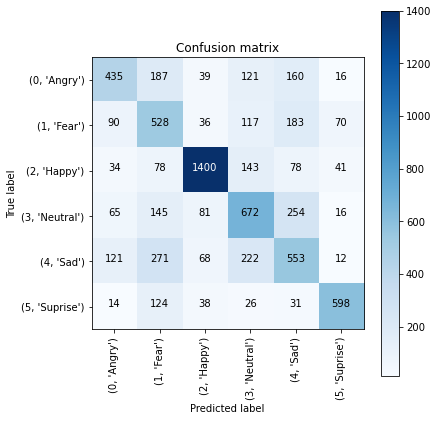

In [40]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)


### Lets try our model and make predictions

In [41]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [42]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

221/221 [==============================] - 2s 8ms/step


In [43]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [44]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Angry,Angry
1,Angry/Angry-10.jpg,Neutral,Angry
2,Angry/Angry-100.jpg,Neutral,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Neutral,Angry


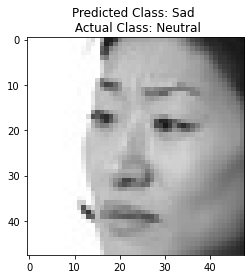

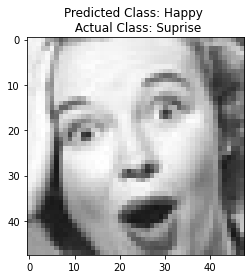

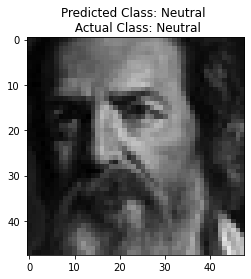

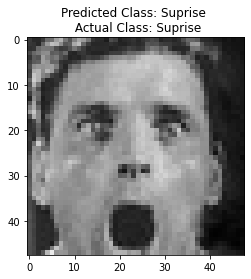

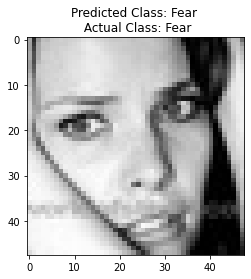

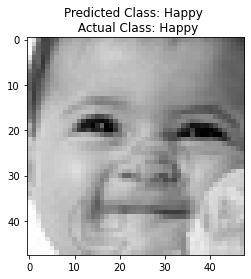

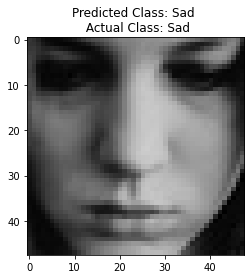

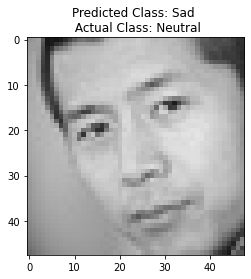

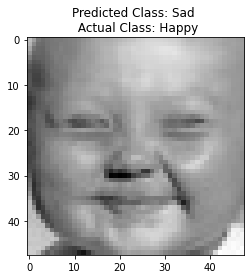

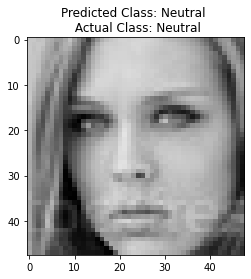

In [45]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass